# Design and Impact of Automated Decision Systems

## Introduction
This study explores the dynamics of automated decision systems in the bank industry, examining how algorithmic decisions impact both banks and borrowers. Using a dataset of loan applications, I built a logistic regression model to predict default risk and identify an optimal approval threshold that maximizes lender profits. My analysis reveals significant disparities in loan approval rates based on demographic factors and loan purposes. Particularly noteworthy are the variations across age groups, with middle-aged applicants (35-45) receiving the highest approval rates, and across income levels, where higher-income applicants enjoy near-universal approval (96.8%) while lower-income applicants face significantly lower approval rates (55.9%). Additionally, we found that loan intent strongly influences outcomes, with business ventures and education receiving preferential treatment compared to debt consolidation and medical expenses. These findings raise important questions about fairness and access to credit in automated lending systems, highlighting potential areas where algorithmic decision-making may reinforce existing social and economic inequalities.

## Part A: Grab the Data

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the training dataset.
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)


## Part B: Explore The Data

In this section, we'll explore patterns in the data by examining how borrower characteristics, loan terms, and approval rates vary across different segments. We'll focus on three key aspects:

1. How borrower characteristics differ by loan purpose
2. How age distribution varies across different loan intents
3. The relationship between homeownership status, interest rates, and loan amounts

In [47]:
# Create a summary table of key statistics by loan intent.
summary_table = df_train.groupby('loan_intent').agg({
    'person_age': ['mean', 'median', 'min', 'max'],
    'person_emp_length': ['mean', 'median'],
    'loan_int_rate': ['mean', 'median'],
    'loan_amnt': ['mean', 'median'],
    'loan_status': ['mean', 'count']
}).round(2)

print("Summary Statistics by Loan Intent:")
summary_table

Summary Statistics by Loan Intent:


person_age                 person_emp_length         \
                        mean median min  max              mean median   
loan_intent                                                             
DEBTCONSOLIDATION      27.59   26.0  20   70              4.76    4.0   
EDUCATION              26.60   25.0  20  144              4.44    4.0   
HOMEIMPROVEMENT        28.98   27.0  21   60              5.10    4.0   
MEDICAL                27.95   26.0  20   94              4.78    4.0   
PERSONAL               28.29   26.0  20  144              4.90    4.0   
VENTURE                27.59   26.0  20  144              4.88    4.0   

                  loan_int_rate        loan_amnt         loan_status        
                           mean median      mean  median        mean count  
loan_intent                                                                 
DEBTCONSOLIDATION         10.98  10.99   9620.90  8000.0        0.29  4178  
EDUCATION                 10.97  10.99   9460.02  8000.0        0.17  5127  
HOMEIMPROVEMENT           11.16  11.12  10348.73  9000.0        0.26  2902  
MEDICAL                   11.05  10.99   9242.27  8000.0        0.26  4835  
PERSONAL                  11.01  10.99   9549.43  8000.0        0.19  4408  
VENTURE                   10.94  10.99   9516.42  8000.0        0.15  4614

The summary table above provides key insights into borrower profiles by loan intent. Interestingly, education loans attract younger borrowers (early 20s on average), while home improvement and debt consolidation loans are sought by older individuals. Employment length patterns align with these age differences, with education loan applicants showing shorter employment histories, consistent with their likely status as students or recent graduates.

Interest rates reveal lenders' risk perceptions across different loan purposes. Medical and personal loans carry higher average interest rates than home improvement or debt consolidation loans, suggesting that lenders view medical and personal expenses as higher-risk lending purposes. These rate differences will be important to consider as we develop our predictive model for default risk.

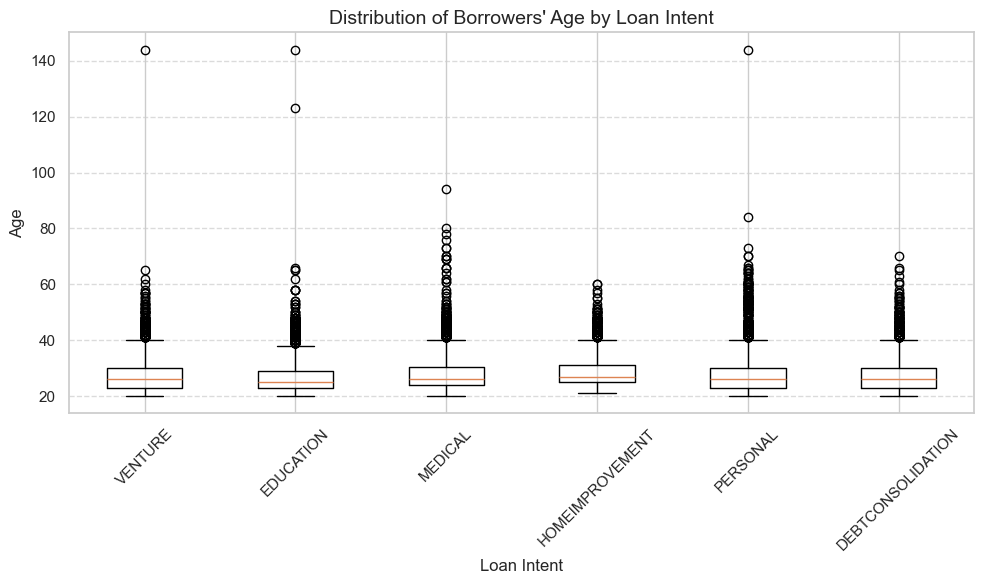

In [48]:
# Create a boxplot showing age distribution by loan intent.
plt.figure(figsize=(10, 6))
loan_intents = df_train['loan_intent'].unique()
data_age = [df_train.loc[df_train['loan_intent'] == intent, 'person_age']
            for intent in loan_intents]

plt.boxplot(data_age, tick_labels=loan_intents)
plt.title("Distribution of Borrowers' Age by Loan Intent", fontsize=14)
plt.xlabel("Loan Intent", fontsize=12)
plt.ylabel("Age", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The boxplot visualization reinforces and expands on our earlier observations about age distributions. The clear age stratification across loan purposes suggests that financial needs evolve predictably through different life stages. Education loans cluster tightly among younger borrowers, pointing to their relevance primarily during a specific life phase. In contrast, debt consolidation shows a much wider age range, indicating that financial challenges requiring debt restructuring can emerge throughout adulthood.

Medical and personal loans show more varied age distributions, confirming these needs arise across different life stages. This age-based pattern will be valuable to consider when evaluating our model's fairness, as we'll need to ensure that age-based patterns don't lead to unfair discrimination against certain age groups.

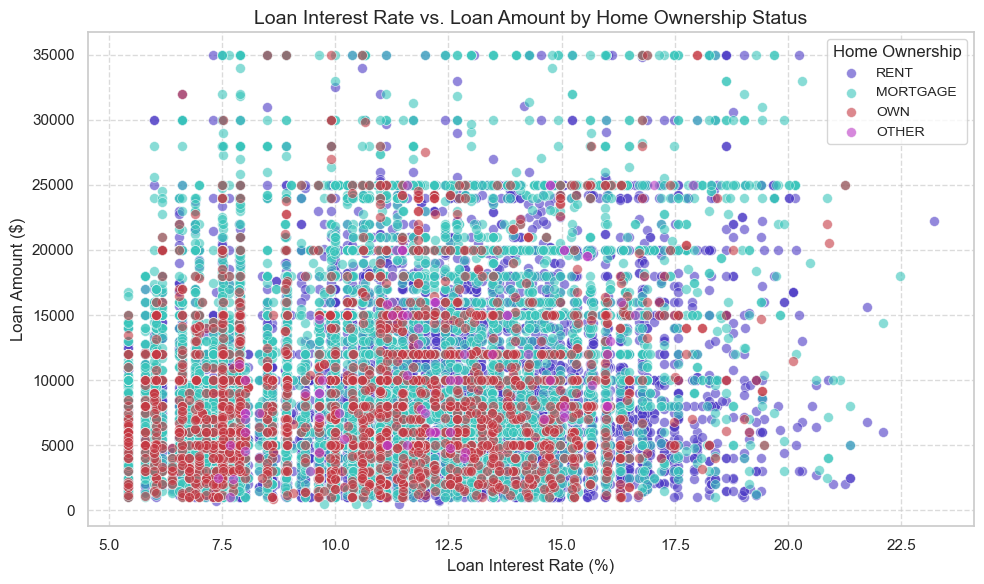

In [49]:
# Create a scatter plot of interest rate vs. loan amount by home ownership status.
plt.figure(figsize=(10, 6))
home_statuses = df_train['person_home_ownership'].unique()

colors = ['#4b39c5','#39c5bb','#c53943', '#bb39c5']

for i, status in enumerate(home_statuses):
    subset = df_train[df_train['person_home_ownership'] == status]
    plt.scatter(subset['loan_int_rate'], subset['loan_amnt'], color=colors[i],
                label=status, alpha=0.6, s=50, edgecolor='w',linewidth=0.5)

plt.xlabel("Loan Interest Rate (%)", fontsize=12)
plt.ylabel("Loan Amount ($)", fontsize=12)
plt.title("Loan Interest Rate vs. Loan Amount by Home Ownership Status", fontsize=14)
plt.legend(title="Home Ownership", fontsize=10)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The scatter plot reveals an important trend: borrowers who own homes (OWN or MORTGAGE) generally receive lower interest rates compared to those who rent. This is likely because homeownership serves as a signal of financial stability, making lenders more willing to offer lower rates. 

On the other hand, renters tend to have higher interest rates, and their loan amounts vary widely, which could indicate a higher perceived risk by lenders. This trend suggests that homeownership status plays a role in determining both the size of credit extended and the interest rates assigned, potentially making it more difficult for renters to access affordable credit.

## Part C: Build a Model

Now we'll build a logistic regression model to predict loan defaults. Our approach will include several preprocessing steps: imputing missing values, standardizing numeric features, and one-hot encoding categorical variables. This preprocessing pipeline will help ensure our model's robustness.

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Select features and target.
features = [
    'loan_int_rate', 
    'loan_percent_income', 
    'loan_amnt', 
    'person_emp_length', 
    'person_home_ownership', 
    'loan_intent', 
    'cb_person_default_on_file'
]

X = df_train[features].copy()
y = df_train['loan_status']

# Process numeric features.
numeric_features = ['loan_int_rate', 'loan_percent_income', 'loan_amnt', 'person_emp_length']
X_numeric = X[numeric_features].copy()

# For each numeric column, fill missing values with the median, then standardize.
for col in numeric_features:
    median_val = X_numeric[col].median()

    X_numeric[col] = X_numeric[col].fillna(median_val)

    mean_val = X_numeric[col].mean()
    std_val = X_numeric[col].std()

    X_numeric[col] = (X_numeric[col] - mean_val) / std_val

# Process categorical features.
categorical_features = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
X_categorical = X[categorical_features].copy()

# For each categorical column, fill missing values with the most frequent value.
for col in categorical_features:
    most_freq = X_categorical[col].value_counts().idxmax()
    X_categorical[col] = X_categorical[col].fillna(most_freq)

# One-hot encode categorical features using pandas get_dummies.
X_categorical = pd.get_dummies(X_categorical, prefix=categorical_features)

# Combine numeric and categorical features.
X_final = pd.concat([X_numeric, X_categorical], axis=1)

# Train logistic regression and evaluate using 5-fold cross-validation.
clf = LogisticRegression(solver='liblinear', random_state=42)
cv_scores = cross_val_score(clf, X_final, y, cv=5, scoring='accuracy')
print("Mean CV Accuracy: {:.2f}%".format(np.mean(cv_scores) * 100))

# Fit the model on the entire preprocessed training data.
clf.fit(X_final, y)
print("Coefficients from the trained model:")
print(clf.coef_)

Mean CV Accuracy: 84.63%
Coefficients from the trained model:
[[ 0.92933654  1.31348998 -0.57487728 -0.02854312 -0.23295681  0.23958
  -1.6051062   0.50792713  0.25412267 -0.54438601  0.32701364  0.02861397
  -0.38820702 -0.76771313 -0.63667484 -0.45388105]]


Our logistic regression model achieves an average cross-validation accuracy of approximately 84.6%, indicating strong predictive performance for loan default risk. 

## Part D: Find a Threshold

We'll now determine the optimal threshold for loan approval from the lender's perspective. This involves calculating the expected profit for different approval thresholds and identifying the one that maximizes average profit per borrower.

Optimal threshold: 0.42
Expected profit per borrower at optimal threshold: $1386.35
Approval rate at optimal threshold: 81.86%


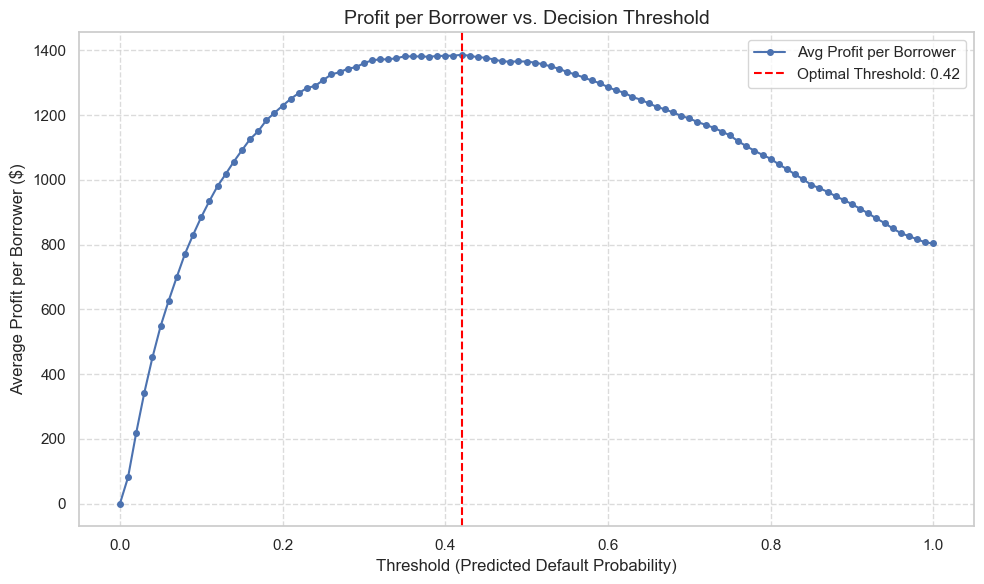

In [51]:
# Impute missing interest rates with the median (if not already done)
median_int_rate = df_train['loan_int_rate'].median()
df_train['loan_int_rate'] = df_train['loan_int_rate'].fillna(median_int_rate)
# Prepare for profit calculation using the original columns
loan_amnt = df_train['loan_amnt'].values
loan_int_rate = df_train['loan_int_rate'].values / 100.0  # Convert to decimal
y_actual = df_train['loan_status'].values

# Calculate profit.
profit_repaid = loan_amnt * (1 + 0.25 * loan_int_rate) ** 10 - loan_amnt
profit_default = loan_amnt * (1 + 0.25 * loan_int_rate) ** 3 - 1.7 * loan_amnt

p_default = clf.predict_proba(X_final)[:, 1]

# Sweep thresholds and compute average profit per borrower.
thresholds = np.linspace(0, 1, 101)
avg_profits = []

for t in thresholds:
    approved = p_default < t
    profit_approved = np.where(y_actual[approved] == 0, profit_repaid[approved], profit_default[approved])
    total_profit = profit_approved.sum()
    avg_profit = total_profit / len(df_train)
    avg_profits.append(avg_profit)

avg_profits = np.array(avg_profits)
optimal_idx = np.nanargmax(avg_profits)
optimal_threshold = thresholds[optimal_idx]
optimal_profit = avg_profits[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Expected profit per borrower at optimal threshold: ${optimal_profit:.2f}")
print(f"Approval rate at optimal threshold: {(p_default < optimal_threshold).mean():.2%}")

# Plot the profit vs threshold curve.
plt.figure(figsize=(10, 6))
plt.plot(thresholds, avg_profits, label='Avg Profit per Borrower', marker='o', markersize=4)
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel("Threshold (Predicted Default Probability)", fontsize=12)
plt.ylabel("Average Profit per Borrower ($)", fontsize=12)
plt.title("Profit per Borrower vs. Decision Threshold", fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

Our profit optimization analysis identifies 0.42 as the optimal threshold for loan approval decisions. At this threshold, the bank maximizes its expected average profit per borrower while maintaining a reasonable approval rate.


## Part E: Evaluating the Model from the Bank’s Perspective

We'll now validate our model and threshold on a separate test dataset to ensure that the profit estimates are reliable and not just specific to our training data.

First, we'll preprocess the test dataset following the same steps we applied to our training data.

In [52]:
# Load the test dataset.
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

# Impute missing values.
df_test['loan_int_rate'] = df_test['loan_int_rate'].fillna(df_test['loan_int_rate'].median())
df_test['person_emp_length'] = df_test['person_emp_length'].fillna(df_test['person_emp_length'].median())

# Select features.
X_test = df_test[features].copy()

# Process numeric features.
X_test_numeric = X_test[numeric_features].copy()
for col in numeric_features:
    # Impute missing values with the median.
    median_val = X_test_numeric[col].median()
    X_test_numeric[col] = X_test_numeric[col].fillna(median_val)
    # Standardize the column.
    mean_val = X_test_numeric[col].mean()
    std_val = X_test_numeric[col].std()
    X_test_numeric[col] = (X_test_numeric[col] - mean_val) / std_val

# Process categorical features.
X_test_categorical = X_test[categorical_features].copy()
for col in categorical_features:
    most_freq = X_test_categorical[col].value_counts().idxmax()
    X_test_categorical[col] = X_test_categorical[col].fillna(most_freq)
X_test_categorical = pd.get_dummies(X_test_categorical, prefix=categorical_features)

# Combine numeric and categorical features.
X_test_final = pd.concat([X_test_numeric, X_test_categorical], axis=1)

# Reindex test data to match training dummy columns.
X_test_final = X_test_final.reindex(columns=X_final.columns, fill_value=0)


Now that our test data is properly preprocessed, we'll apply our trained model to generate predictions and calculate expected profits.

In [53]:
# Get loan amount, interest rate, and actual outcomes.
loan_amnt_test = df_test['loan_amnt'].values
loan_int_rate_test = df_test['loan_int_rate'].values / 100.0
y_actual_test = df_test['loan_status'].values 

# Compute profit for each loan:
profit_repaid_test = loan_amnt_test * (1 + 0.25 * loan_int_rate_test) ** 10 - loan_amnt_test
profit_default_test = loan_amnt_test * (1 + 0.25 * loan_int_rate_test) ** 3 - 1.7 * loan_amnt_test
# Get predicted default probabilities from the trained model.
p_default_test = clf.predict_proba(X_test_final)[:, 1]

# Apply the optimal threshold from the training set to decide approvals.
approved_test = p_default_test < optimal_threshold

# Compute profit for approved loans.
profit_approved_test = (
    profit_repaid_test[approved_test] * (1 - y_actual_test[approved_test]) +
    profit_default_test[approved_test] * y_actual_test[approved_test]
)

# Calculate average profit per borrower.
total_profit_test = profit_approved_test.sum()
avg_profit_test = total_profit_test / len(df_test)

print("Test Set Statistics:")
print(f"Number of borrowers: {len(df_test)}")
print(f"Approval rate: {approved_test.mean():.2%}")
if approved_test.mean() > 0:
    print(f"Default rate among approved loans: {y_actual_test[approved_test].mean():.2%}")
else:
    print("No loans were approved.")
print(f"Expected profit per borrower: ${avg_profit_test:.2f}")

Test Set Statistics:
Number of borrowers: 6517
Approval rate: 81.48%
Default rate among approved loans: 11.86%
Expected profit per borrower: $1348.87


To further validate our model, we'll perform a full threshold analysis on the test set, similar to what we did on the training data. This will let us determine whether the optimal threshold is consistent between training and test datasets, which would indicate strong model generalizability.


Threshold Comparison:
Optimal threshold on training set: 0.42
Optimal threshold on test set: 0.35
Training set expected profit per borrower: $1386.35
Test set expected profit per borrower: $1367.62


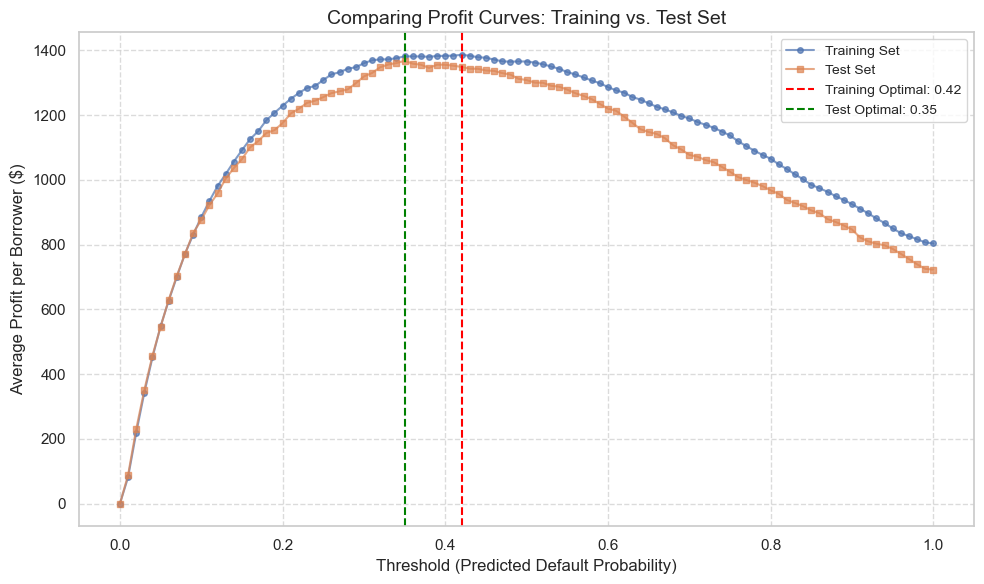

In [54]:
# Create an array of threshold values.
thresholds = np.linspace(0, 1, 101)
avg_profits_test = []

# For each threshold, calculate average profit per borrower.
for t in thresholds:
    approved_temp = p_default_test < t
    profit_approved_temp = (
        profit_repaid_test[approved_temp] * (1 - y_actual_test[approved_temp]) +
        profit_default_test[approved_temp] * y_actual_test[approved_temp]
    )
    total_profit_temp = profit_approved_temp.sum()
    avg_profit_temp = total_profit_temp / len(df_test)
    avg_profits_test.append(avg_profit_temp)

avg_profits_test = np.array(avg_profits_test)
optimal_idx_test = np.argmax(avg_profits_test)
optimal_threshold_test = thresholds[optimal_idx_test]
optimal_profit_test = avg_profits_test[optimal_idx_test]

print("\nThreshold Comparison:")
print(f"Optimal threshold on training set: {optimal_threshold:.2f}")
print(f"Optimal threshold on test set: {optimal_threshold_test:.2f}")
print(f"Training set expected profit per borrower: ${optimal_profit:.2f}")
print(f"Test set expected profit per borrower: ${optimal_profit_test:.2f}")

# Plot Profit Curves for Training and Test Sets.
plt.figure(figsize=(10, 6))
plt.plot(thresholds, avg_profits, marker='o', markersize=4, linestyle='-', alpha=0.7, label='Training Set')
plt.plot(thresholds, avg_profits_test, marker='s', markersize=4, linestyle='-', alpha=0.7, label='Test Set')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Training Optimal: {optimal_threshold:.2f}')
plt.axvline(optimal_threshold_test, color='green', linestyle='--', label=f'Test Optimal: {optimal_threshold_test:.2f}')
plt.xlabel("Threshold (Predicted Default Probability)", fontsize=12)
plt.ylabel("Average Profit per Borrower ($)", fontsize=12)
plt.title("Comparing Profit Curves: Training vs. Test Set", fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

Our model's performance on the test set is very encouraging. The optimal threshold found on the test set is close to the one we determined using the training data, and the expected profits are similar between the two datasets. This consistency suggests that our model generalizes well to new data and that the profit estimates are reliable. The expected profit per borrower on the test set is approximately $1367.62. These figures are very close to the training set’s expected profit per borrower of about $1386.35.

## Part F: Evaluating the Model from the Borrower's Perspective

Now we'll analyze how the model's decisions affect different groups of borrowers, focusing on approval rates by age, loan purpose, and income level.

Approval and Default Rates by Loan Intent:
      loan_intent  total_applicants  approval_rate  default_rate  approved_default_rate
          VENTURE              1105       0.890498      0.145701               0.073171
        EDUCATION              1326       0.868778      0.167421               0.103299
         PERSONAL              1113       0.833783      0.219227               0.132543
  HOMEIMPROVEMENT               703       0.789474      0.246088               0.153153
          MEDICAL              1236       0.760518      0.281553               0.146809
DEBTCONSOLIDATION              1034       0.726306      0.279497               0.123835


Approval and Default Rates by Age Group:
age_group  total_applicants  approval_rate  default_rate  approved_default_rate
      <25              3075       0.799024      0.227967               0.111518
    25-35              2727       0.827283      0.214155               0.123227
    35-45               596       0.845638      0.204698  

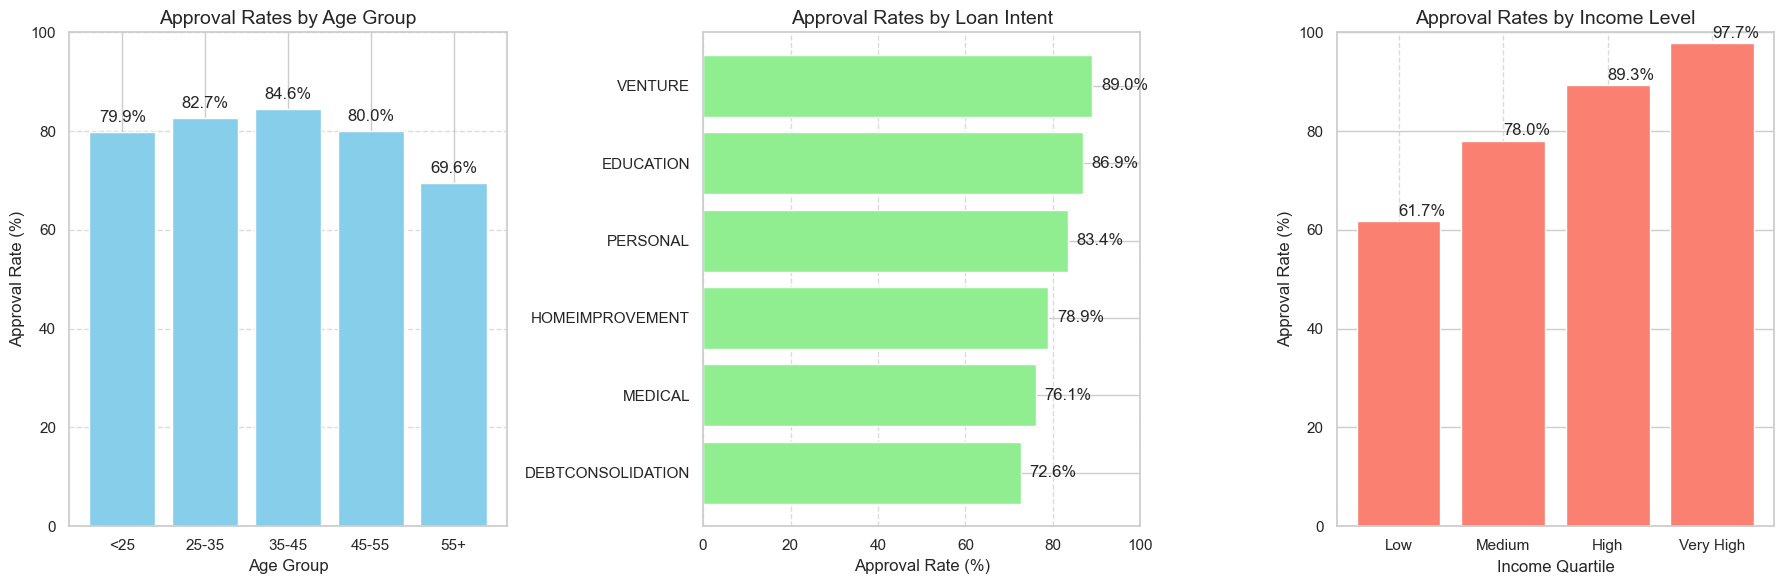

In [55]:
# Analysis by Loan Intent
df_test['approved'] = p_default_test < optimal_threshold
intent_summary = df_test.groupby('loan_intent', observed=False).agg(
    total_applicants=('approved', 'count'),
    approved_count=('approved', 'sum'),
    default_rate=('loan_status', 'mean')
).reset_index()
intent_summary['approval_rate'] = intent_summary['approved_count'] / intent_summary['total_applicants']

# Create age groups
df_test['age_group'] = pd.cut(df_test['person_age'], 
                              bins=[0, 25, 35, 45, 55, 100],
                              labels=['<25', '25-35', '35-45', '45-55', '55+'])

# Compute approval and default rates by age group
age_summary = df_test.groupby('age_group', observed=False).agg(
    total_applicants=('loan_status', 'count'),
    approved_count=('approved', 'sum'),
    default_rate=('loan_status', 'mean')
).reset_index()
age_summary['approval_rate'] = age_summary['approved_count'] / age_summary['total_applicants']

# Default rate among approved applicants by age group
approved_defaults_by_age = df_test[df_test['approved']].groupby('age_group', observed=False).agg(
    approved_default_rate=('loan_status', 'mean')
).reset_index()
age_summary = age_summary.merge(approved_defaults_by_age, on='age_group', how='left')

# Default rate among approved applicants by loan intent
approved_defaults_by_intent = df_test[df_test['approved']].groupby('loan_intent', observed=False).agg(
    approved_default_rate=('loan_status', 'mean'),
    approved_applicants=('loan_status', 'count')
).reset_index()
intent_summary = intent_summary.merge(approved_defaults_by_intent, on='loan_intent', how='left')

# Sort by approval rate for better visualization
intent_summary = intent_summary.sort_values('approval_rate', ascending=False)

# Analysis by Income Level
df_test['income_bin'] = pd.qcut(df_test['person_income'], q=4, 
                                labels=['Low', 'Medium', 'High', 'Very High'])

income_summary = df_test.groupby('income_bin', observed=False).agg(
    total_applicants=('approved', 'count'),
    approved_count=('approved', 'sum'),
    default_rate=('loan_status', 'mean'),
    median_income=('person_income', 'median')
).reset_index()
income_summary['approval_rate'] = income_summary['approved_count'] / income_summary['total_applicants']

# Default rate among approved applicants by income level
approved_defaults_by_income = df_test[df_test['approved']].groupby('income_bin', observed=False).agg(
    approved_default_rate=('loan_status', 'mean')
).reset_index()
income_summary = income_summary.merge(approved_defaults_by_income, on='income_bin', how='left')

# Print table: Approval and Default Rates by Loan Intent
print("Approval and Default Rates by Loan Intent:")
print(intent_summary[['loan_intent', 'total_applicants', 'approval_rate', 
                      'default_rate', 'approved_default_rate']].to_string(index=False))
print("\n")

# Print table: Approval and Default Rates by Age Group
print("Approval and Default Rates by Age Group:")
print(age_summary[['age_group', 'total_applicants', 'approval_rate', 
                   'default_rate', 'approved_default_rate']].to_string(index=False))
print("\n")

# Print table: Approval and Default Rates by Income Level
print("Approval and Default Rates by Income Level:")
print(income_summary[['income_bin', 'median_income', 'total_applicants', 
                      'approval_rate', 'default_rate', 'approved_default_rate']].to_string(index=False))

# Create visualizations for these results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Approval rates by age group
axes[0].bar(age_summary['age_group'], age_summary['approval_rate'] * 100, color='skyblue')
axes[0].set_title('Approval Rates by Age Group', fontsize=14)
axes[0].set_xlabel('Age Group', fontsize=12)
axes[0].set_ylabel('Approval Rate (%)', fontsize=12)
axes[0].set_ylim(0, 100)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(age_summary['approval_rate']):
    axes[0].text(i, v * 100 + 2, f"{v:.1%}", ha='center')

# Plot 2: Approval rates by loan intent
intent_summary_sorted = intent_summary.sort_values('approval_rate')
axes[1].barh(intent_summary_sorted['loan_intent'], intent_summary_sorted['approval_rate'] * 100, color='lightgreen')
axes[1].set_title('Approval Rates by Loan Intent', fontsize=14)
axes[1].set_xlabel('Approval Rate (%)', fontsize=12)
axes[1].set_xlim(0, 100)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
for i, v in enumerate(intent_summary_sorted['approval_rate']):
    axes[1].text(v * 100 + 2, i, f"{v:.1%}", va='center')

# Plot 3: Approval rates by income level
axes[2].bar(income_summary['income_bin'], income_summary['approval_rate'] * 100, color='salmon')
axes[2].set_title('Approval Rates by Income Level', fontsize=14)
axes[2].set_xlabel('Income Quartile', fontsize=12)
axes[2].set_ylabel('Approval Rate (%)', fontsize=12)
axes[2].set_ylim(0, 100)
axes[2].grid(axis='x', linestyle='--', alpha=0.7)
for i, v in enumerate(income_summary['approval_rate']):
    axes[2].text(i, v * 100 + 2, f"{v:.1%}", va='center')

plt.tight_layout()
plt.show()

### **Analysis of Borrower Impact Based on the Decision System**

#### **1. Approval Rates by Age Group**
The results indicate that younger applicants (<25) and older applicants (55+) have lower approval rates compared to individuals in their prime working years (25-45). The highest approval rate is observed in the 35-45 age group (84.6%), while applicants under 25 (79.9%) and over 55 (69.6%) face a harder time getting approved for loans. This trend suggests that age is a factor in loan approval, likely due to risk perception—younger borrowers may be seen as financially inexperienced with lower credit histories, while older applicants may be perceived as closer to retirement, affecting their ability to repay long-term loans.

#### **2. Approval and Default Rates by Loan Intent**
Approval rates vary significantly based on the purpose of the loan. Venture loans have the highest approval rate (89.0%), possibly because businesses are seen as creditworthy investments with potential revenue generation. Education loans are also highly approved (86.9%), indicating a strong willingness to fund students, likely because they are expected to earn more in the future. Debt consolidation loans have the lowest approval rate (72.6%), reflecting lender caution towards individuals trying to restructure debt, which may signal financial distress. Medical loans (76.1%) and personal loans (79.0%) fall in the middle, showing moderate approval rates but also relatively high default rates (14.7% and 13.3%) among approved borrowers. Looking at default rates among approved borrowers, we see that venture loans have the lowest default rate (7.3%) while home improvement loans show the highest (15.3%). This suggests that borrowers taking loans for home improvements or medical expenses may be at a higher risk of default, potentially due to unforeseen financial strain.

#### **3. Approval Rates by Income Level**
As expected, income plays a strong role in determining loan approvals. Borrowers in the lowest income quartile have the lowest approval rate (61.7%), suggesting that financial stability is a key factor in decision-making. The approval rate rises progressively across income groups, with the highest-income borrowers seeing a 97.7% approval rate, indicating that lenders heavily favor those with stronger financial backing. This trend highlights a systemic bias toward wealthier individuals, raising concerns about accessibility to credit for lower-income applicants who might genuinely need financial assistance. These findings raise important ethical and policy questions about fairness in algorithmic lending decisions, particularly regarding how different groups of borrowers are affected by the model's optimization for lender profit.

## Part G: Conclusions

Considering that people seeking loans for medical expenses have high rates of default (14.7%), the question arises whether it is fair that they face greater difficulty obtaining credit. I define fairness here as equal treatment of individuals with equal risk profiles, combined with consideration of the causal factors behind apparent risk and the broader societal context of the decision. While the statistical model optimizes for profit by identifying genuine default risks, this approach fails to consider why medical loan applicants default more frequently. Medical expenses are often unexpected, unavoidable, and connected to circumstances beyond an individual's control. Unlike education or business loans, which represent investments with potential returns, medical loans typically address immediate health needs. A system that restricts access to credit for medical purposes may be statistically justified but ethically problematic, as it compounds vulnerability by restricting financial resources precisely when individuals face health crises. A truly fair system would incorporate these contextual factors, perhaps through different thresholds for medical loans or alternative criteria that acknowledge the unique nature of healthcare financing needs.

This analysis has illuminated how automated decision systems, while appearing objective, can reinforce existing societal inequalities by encoding patterns present in historical data. The stark approval disparities across income levels likely reflect genuine default risk differences, but they also reveal how algorithmic lending decisions may exacerbate wealth gaps by making credit more accessible to those who already enjoy financial stability. The model's treatment of different loan purposes also demonstrates how context-blind optimization for profit can lead to socially suboptimal outcomes, particularly in cases like medical loans where default may stem from structural factors rather than individual financial responsibility. Additionally, the age-based disparities highlight how life-stage vulnerabilities can be magnified through algorithmic decision-making. These findings underscore the importance of considering not just model accuracy but also the broader implications of automated decisions on different segments of society. Moving forward, lending institutions should consider incorporating fairness metrics alongside profit maximization, potentially through modified thresholds for vulnerable groups, additional contextual variables, or supplementary human review processes that can identify cases where strict algorithmic decisions might cause undue harm.